In [1]:
import numpy as np
import glob
import os

# for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
#from matplotlib.colors import LogNorm
%matplotlib inline

from PIL import Image 
# Nedded for background fit
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize

# needed for spotfinder
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

# custom functions
from DefDefDefinitions import PE_Vals
from DefDefDefinitions import Image_Converter
from DefDefDefinitions import FrequencyFilterFunction
from DefDefDefinitions import FFT_Filter
from DefDefDefinitions import Unique_Circle
from DefDefDefinitions import Fit_2D_Gaussian
from DefDefDefinitions import gaussian_2d
from DefDefDefinitions import Spot_finder
from DefDefDefinitions import Spot_Area
from DefDefDefinitions import Step_fit
from DefDefDefinitions import Line_fit
from DefDefDefinitions import moving_average
from DefDefDefinitions import Trajectory

In [2]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [3]:
cwd = os.getcwd()
Dir = cwd+'/../Test_Data/'
Dir = '/Users/austinmcdonald/Data/5/'

In [4]:
DataFiles = glob.glob(Dir+'*')
DataFiles = natural_sort(DataFiles)
print("Found "+str(len(DataFiles))+" Files")

Found 300 Files


In [5]:
DataFiles

['/Users/austinmcdonald/Data/5/1pM18c6Acr5_1.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_2.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_3.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_4.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_5.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_6.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_7.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_8.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_9.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_10.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_11.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_12.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_13.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_14.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_15.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_16.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_17.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_18.tif',
 '/Users/austinmcdonald/Data/5/1pM18c6Acr5_19.tif',
 '/Users/austinmcdona

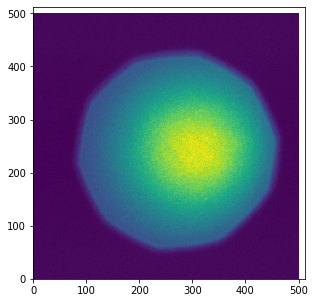

In [6]:
# Import one file to see how it all looks good

Row    = int(250)
Col    = Row
Yindex = int(256)
Xindex = int(256)

eOffset, eCoeff = PE_Vals(DataFiles[0])
Test = Image_Converter(DataFiles[0], eOffset, eCoeff, Xindex, Yindex, Row, Col)
Shape = Test.shape[0]

plt.figure(figsize=(5,5))
plt.imshow(Test)
plt.xlim(0,512)
plt.ylim(0,512)
plt.show()

In [7]:
#Setup the FFT filter paramaters
FreqCut=0.03
FreqCutWidth=0.04
#Filter=lambda x: (0.5+np.tanh((x-FreqCut)/FreqCutWidth)/2.)
#plot it
#plt.title("Frequency filter function'")
#vars=np.arange(0,0.5,0.01)
#plt.plot(vars,Filter(vars))     
FilterArray = FrequencyFilterFunction(Shape,FreqCut,FreqCutWidth)

In [76]:
# Loading all of the files into a dictonary after being FFTed
# this may take a minuet
FRAMES = {}
for img in DataFiles:
    DirName    = img.split('/')[-2]
    FileName   = img.split('/')[-1]
    FrameIndex = FileName.split('_')[-1].split('.tif')[0]
    FrameName  = DirName+'_'+FrameIndex

    eOffset, eCoeff = PE_Vals(img)
    ReducedImage = Image_Converter(img, eOffset, eCoeff, Xindex, Yindex, Row, Col)
    
    #FRAMES[FrameName] = FFT_Filter(ReducedImage, FilterArray)
    FRAMES[FrameName] = ReducedImage
    

In [9]:
# Making a summed image
KEYS = list(FRAMES.keys())
SUMMEDFFT = np.zeros(Shape**2).reshape((Shape,Shape))
for keys in KEYS:
    SUMMEDFFT += FRAMES[keys]
SUMMEDFFT = SUMMEDFFT/len(KEYS)

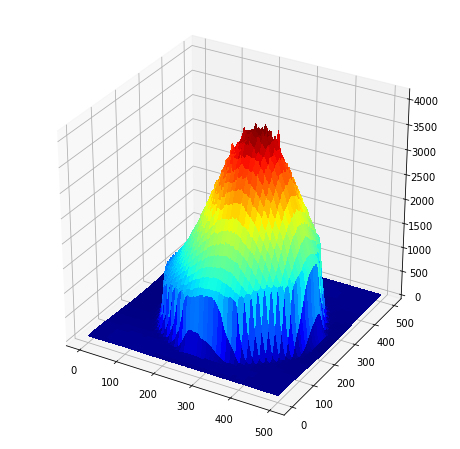

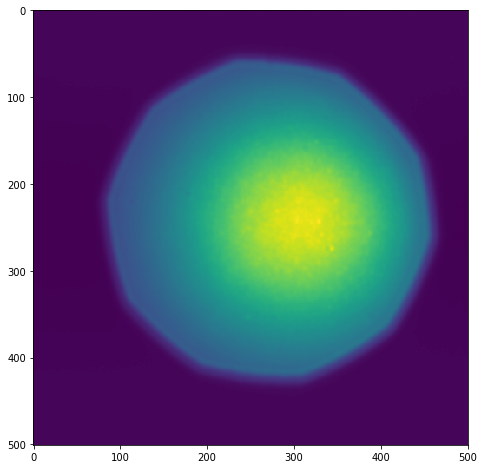

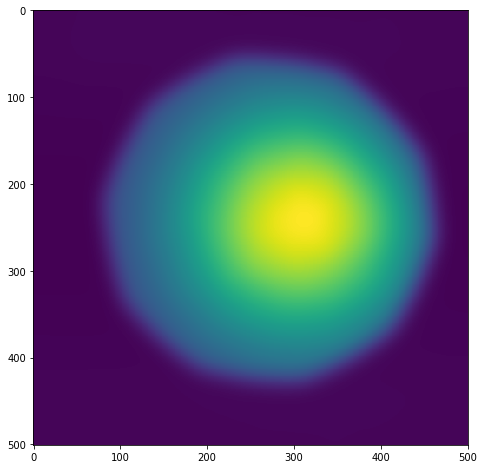

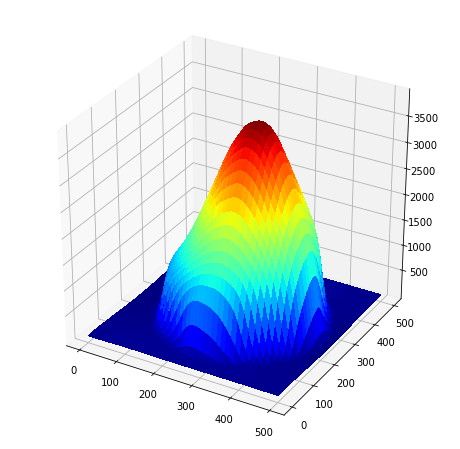

In [10]:
#plotting the summed image and showing the blur method for removing the background
plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
data = SUMMEDFFT-np.min(SUMMEDFFT)
ypos, xpos  = np.indices(data.shape) 
ax.plot_surface(xpos, ypos, data, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(data)
plt.show()

blur = ndimage.gaussian_filter(data,10)
plt.figure(figsize=(8,8))
plt.imshow(blur)
plt.show()

plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
ax.plot_surface(xpos, ypos, blur, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()



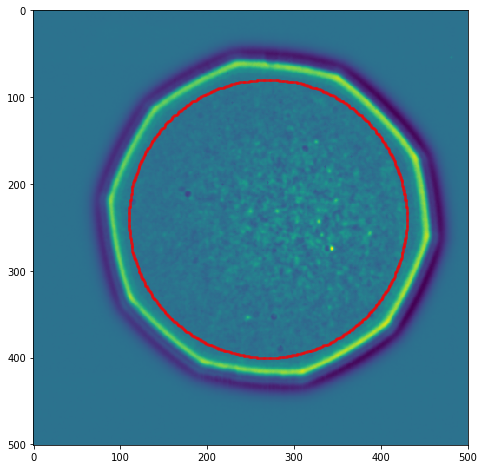

In [11]:
#Setting the fiducal are to cut out the iris effects
Blured = data-blur
plt.figure(figsize=(8,8))
plt.imshow(Blured)
r = 160
Xoff = 270
Yoff = 240

X_circle, Y_circle = Unique_Circle(r, Xoff, Yoff, Shape)

plt.scatter(X_circle,Y_circle,color='r',lw=2,alpha=0.4,s=1)

plt.show()

In [12]:
# based on that cut this matrix if formed
# to kill everything outside of the circle

KILL  = np.zeros(Shape**2).reshape((Shape,Shape))
r_cut  = np.sqrt((X_circle-Xoff)**2+(Y_circle-Yoff)**2).max()
for r in range(SUMMEDFFT.shape[0]):
    for c in range(SUMMEDFFT.shape[0]):
        rr = np.sqrt((r-Yoff)**2+(c-Xoff)**2)
        if rr<=r_cut:
            KILL[r,c]=1

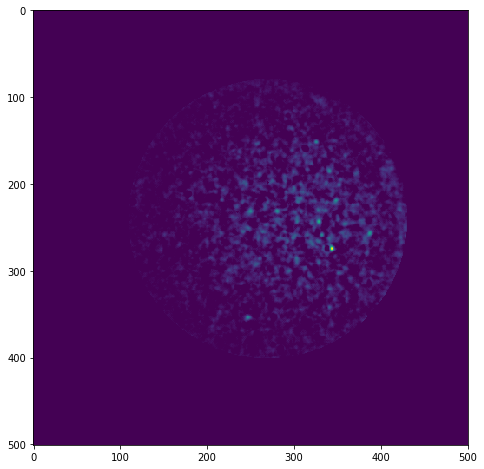

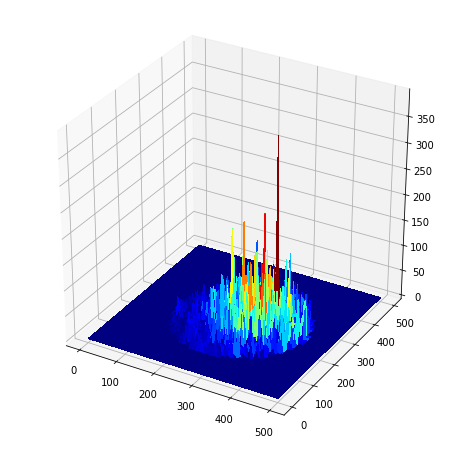

In [13]:
# show the result of the above steps
Data = Blured*KILL
Data[Data<0]=0

plt.figure(figsize=(8,8))
plt.imshow(Data)
plt.show()

plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
ax.plot_surface(xpos, ypos, Data, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()

In [14]:
neighborhood_size = 14
threshold_sigma = 3
EdgeCut = 5  
spots = Spot_finder(Data, neighborhood_size, threshold_sigma, Shape, EdgeCut)
print("found spots ", len(spots))

found spots  169


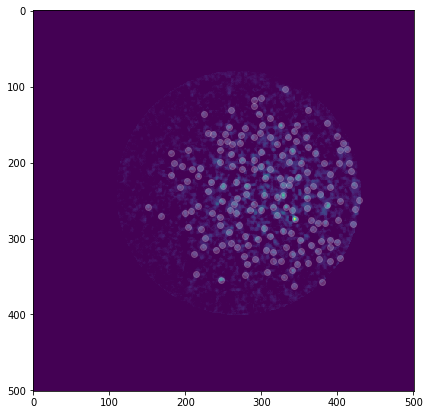

In [15]:
plt.figure(figsize=(7,7))
plt.imshow(Data)
plt.scatter(spots[:,0],spots[:,1],color='w',alpha=0.2)
plt.show()

In [117]:
# this goes through the IDed spots and gets the area for the 
# fluorescence trajectorys uses Rbkg,Rsig as the radius of
# around the point it picks for the area
KEYS = list(FRAMES.keys())
Rbkg = int(6)
Rsig = int(2)

Rbkg = int(5)
Rsig = int(2)
spot_area = Spot_Area(FRAMES, KEYS, spots, Rbkg, Rsig)

In [118]:
# this goes through the IDed spots and make the fluorescence trajectory
# adds all of that into a class 

Traject = {}
AVG = 2
Exposure = 0.5
Num_Spots = len(spots)
print("found "+str(Num_Spots)+" spots!")
#for x in range(0,1):
for x in range(0,Num_Spots):
    X = str(int(spots[x][0]))
    Y = str(int(spots[x][1]))
    if X=="326" and Y=="151":
        print(x)
    NAME = "X"+X+"_Y"+Y
    sig = np.array(spot_area[x::Num_Spots])[:,2]
    bkg = np.array(spot_area[x::Num_Spots])[:,3]

    sig = np.add.reduceat(sig, np.arange(0, len(sig), AVG))
    bak = np.add.reduceat(bkg, np.arange(0, len(bkg), AVG))
    times    = np.arange(0,len(sig))*Exposure*AVG

    baerry = np.sqrt(sig*(2*Rsig+1)**2)
    naerry = np.sqrt(bak*((2*Rbkg+1)**2-(2*Rsig+1)**2))
    
    #baerry = np.sqrt(sig)
    #naerry = np.sqrt(bak)
    
    coefsF = poly.polyfit(times,bak, 9)
    ffitF  = poly.polyval(times, coefsF)


    fitS = (sig-ffitF)
    fitSbk = baerry/(2*Rsig+1)**2
    fitB = (bak-ffitF)
    fitBbk = naerry/((2*Rbkg+1)**2-(2*Rsig+1)**2)

    Meandiff, chiStep, LT = Step_fit(times,fitS,fitSbk)
    chiLine     = Line_fit(times,fitS,fitSbk)

    Trj = Trajectory()
    Trj.name = NAME
    Trj.Mean_diff = Meandiff
    Trj.Chi_Step = chiStep
    Trj.Chi_Line = chiLine
    Trj.Step_Time = LT
    Trj.Times = times
    Trj.Signal = fitS
    Trj.Signal_er = fitSbk
    Trj.Background = fitB
    Trj.Background_er = fitBbk


    Traject[NAME] = Trj

found 169 spots!
12


In [119]:
x=12
sig = np.array(spot_area[x::Num_Spots])[:,2]
bkg = np.array(spot_area[x::Num_Spots])[:,3]

sig = np.add.reduceat(sig, np.arange(0, len(sig), AVG))
bak = np.add.reduceat(bkg, np.arange(0, len(bkg), AVG))
times    = np.arange(0,len(sig))*Exposure*AVG

baerry = np.sqrt(sig*(2*Rsig+1)**2)
naerry = np.sqrt(bak*((2*Rbkg+1)**2-(2*Rsig+1)**2))
coefsF = poly.polyfit(times,bak, 9)
ffitF  = poly.polyval(times, coefsF)


fitS = (sig-ffitF)
fitSbk = baerry/(2*Rsig+1)**2
fitB = (bak-ffitF)
fitBbk = naerry/((2*Rbkg+1)**2-(2*Rsig+1)**2)

Meandiff, chiStep, LT = Step_fit(times,fitS,fitSbk)
chiLine     = Line_fit(times,fitS,fitSbk)

In [120]:
(2*Rsig+1)**2

25

In [121]:
((2*Rbkg+1)**2-(2*Rsig+1)**2)

96

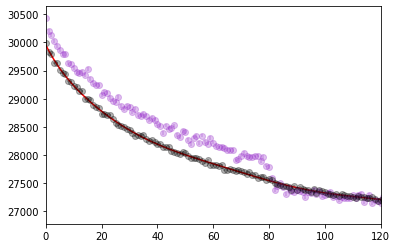

(0, 120)

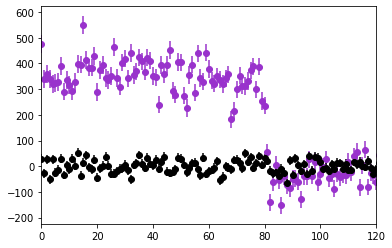

In [122]:
plt.errorbar(times, sig, yerr=fitSbk ,fmt='o',color='darkorchid',label="sig raw",alpha=0.3)
plt.errorbar(times, bak, yerr=fitBbk ,fmt='o',color='k',label="bak raw",alpha=0.3)
plt.plot(times, ffitF,color='r', label="fit")
#plt.xlim(60,100)
plt.xlim(0,120)
plt.show()

plt.errorbar(times, sig-ffitF, yerr=fitSbk ,fmt='o',color='darkorchid',label="sig raw")
plt.errorbar(times, bak-ffitF, yerr=fitBbk ,fmt='o',color='k',label="bak raw")
plt.xlim(60,100)
plt.xlim(0,120)


<ErrorbarContainer object of 3 artists>

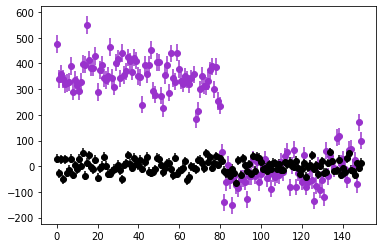

In [123]:
plt.errorbar(times, sig-ffitF, yerr=fitSbk ,fmt='o',color='darkorchid',label="sig raw")
plt.errorbar(times, bak-ffitF, yerr=fitBbk ,fmt='o',color='k',label="bak raw")

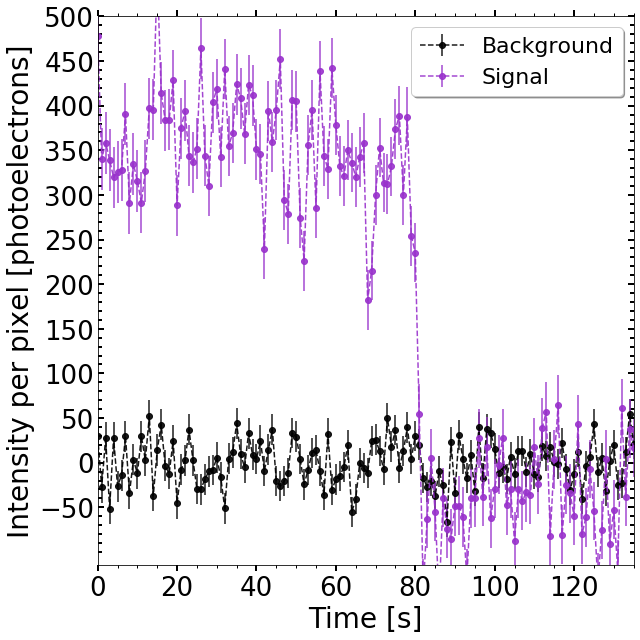

In [140]:
mv_avg = 4
SPOT = "X315_Y394"
SPOT = "X326_Y151"
fig, ax = plt.subplots(figsize=(9,9))

ax.errorbar(Traject[SPOT].Times ,Traject[SPOT].Background,
             yerr=Traject[SPOT].Background_er, fmt='o', alpha=0.9,label='Background',color='k',linestyle='--')
xx = moving_average(Traject[SPOT].Times,mv_avg)
yy = moving_average(Traject[SPOT].Background,mv_avg)
#ax.plot(xx,yy,color='k',label='moving avg',linestyle=':',linewidth=4)


ax.errorbar(Traject[SPOT].Times ,Traject[SPOT].Signal,
             yerr=Traject[SPOT].Signal_er, fmt='o', alpha=0.9,label='Signal',color='darkorchid',linestyle='--')
xx = moving_average(Traject[SPOT].Times,mv_avg)
yy = moving_average(Traject[SPOT].Signal,mv_avg)
#ax.plot(xx,yy,color='darkorchid',label='moving avg',linestyle=':',linewidth=4)



ax.set_xlabel(r'Time [s]', fontsize=28)
ax.set_ylabel('Intensity per pixel [photoelectrons]', fontsize=28)

ax.legend(fontsize=22,shadow=True, fancybox=True,ncol=1,loc='upper right')

plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)

xmajor_ticks = np.arange(0, 400, 20)
xminor_ticks = np.arange(0, 400, 5)
ymajor_ticks = np.arange(-50, 550, 50)
yminor_ticks = np.arange(-100, 550, 10)
ax.tick_params(axis = 'x', which = 'major', direction='out',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'x', which = 'minor', direction='out',width=1,length=3,top="off",right='off')

ax.tick_params(axis = 'y', which = 'major', direction='in',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'y', which = 'minor', direction='in',width=2,length=4,top="off",right='off')

newpos = xmajor_ticks - 0
ax.set_xticklabels(newpos)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor = True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor = True)

ax.set_xlim(0,160)
ax.set_xlim(0,135)
ax.set_ylim(-115,500)
#plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/HP-step.pdf',bbox_inches='tight')
plt.show()

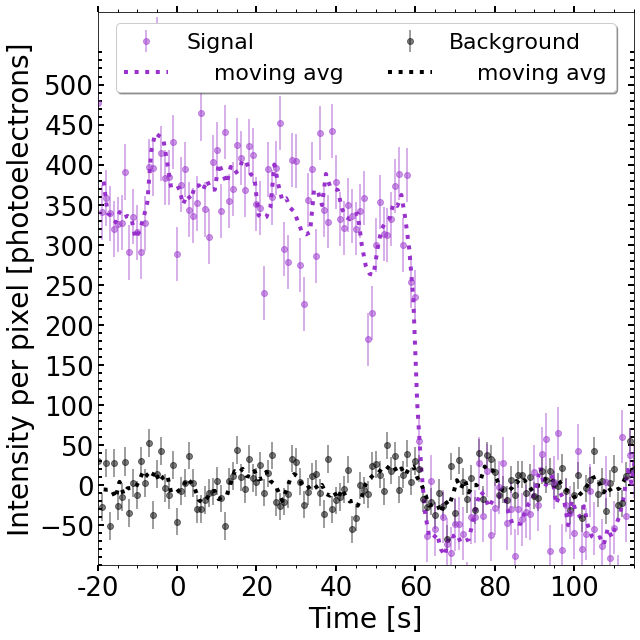

In [128]:
mv_avg = 4
SPOT = "X315_Y394"
SPOT = "X326_Y151"
fig, ax = plt.subplots(figsize=(9,9))

ax.errorbar(Traject[SPOT].Times ,Traject[SPOT].Background,
             yerr=Traject[SPOT].Background_er, fmt='o', alpha=0.5,label='Background',color='k')
xx = moving_average(Traject[SPOT].Times,mv_avg)
yy = moving_average(Traject[SPOT].Background,mv_avg)
ax.plot(xx,yy,color='k',label='moving avg',linestyle=':',linewidth=4)


ax.errorbar(Traject[SPOT].Times ,Traject[SPOT].Signal,
             yerr=Traject[SPOT].Signal_er, fmt='o', alpha=0.5,label='Signal',color='darkorchid')
xx = moving_average(Traject[SPOT].Times,mv_avg)
yy = moving_average(Traject[SPOT].Signal,mv_avg)
ax.plot(xx,yy,color='darkorchid',label='moving avg',linestyle=':',linewidth=4)



ax.set_xlabel(r'Time [s]', fontsize=28)
ax.set_ylabel('Intensity per pixel [photoelectrons]', fontsize=28)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[1], handles[2], handles[0]]


labels = [labels[3], '    '+labels[1], labels[2], '    '+labels[0]]
ax.legend(handles,labels,fontsize=22,shadow=True, fancybox=True,ncol=2,loc='upper center')

plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)

xmajor_ticks = np.arange(0, 400, 20)
xminor_ticks = np.arange(0, 400, 5)
ymajor_ticks = np.arange(-50, 550, 50)
yminor_ticks = np.arange(-100, 550, 10)
ax.tick_params(axis = 'x', which = 'major', direction='out',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'x', which = 'minor', direction='out',width=1,length=3,top="off",right='off')

ax.tick_params(axis = 'y', which = 'major', direction='in',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'y', which = 'minor', direction='in',width=2,length=4,top="off",right='off')

newpos = xmajor_ticks - 20
ax.set_xticklabels(newpos)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor = True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor = True)

ax.set_xlim(0,160)
ax.set_xlim(0,135)
ax.set_ylim(-100,590)
#plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/HP-step.pdf',bbox_inches='tight')
plt.show()

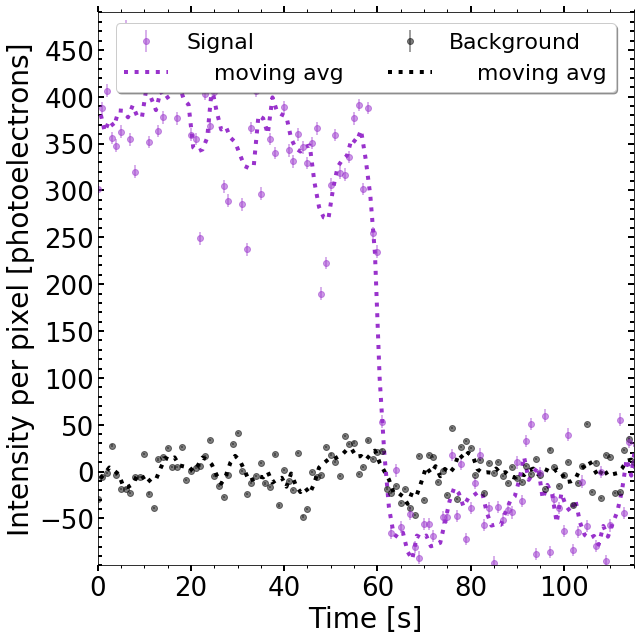

In [93]:
mv_avg = 4
SPOT = "X315_Y394"
SPOT = "X326_Y151"
fig, ax = plt.subplots(figsize=(9,9))

ax.errorbar(Traject[SPOT].Times ,Traject[SPOT].Background,
             yerr=Traject[SPOT].Background_er, fmt='o', alpha=0.5,label='Background',color='k')
xx = moving_average(Traject[SPOT].Times,mv_avg)
yy = moving_average(Traject[SPOT].Background,mv_avg)
ax.plot(xx,yy,color='k',label='moving avg',linestyle=':',linewidth=4)


ax.errorbar(Traject[SPOT].Times ,Traject[SPOT].Signal,
             yerr=Traject[SPOT].Signal_er, fmt='o', alpha=0.5,label='Signal',color='darkorchid')
xx = moving_average(Traject[SPOT].Times,mv_avg)
yy = moving_average(Traject[SPOT].Signal,mv_avg)
ax.plot(xx,yy,color='darkorchid',label='moving avg',linestyle=':',linewidth=4)



ax.set_xlabel(r'Time [s]', fontsize=28)
ax.set_ylabel('Intensity per pixel [photoelectrons]', fontsize=28)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[1], handles[2], handles[0]]


labels = [labels[3], '    '+labels[1], labels[2], '    '+labels[0]]
ax.legend(handles,labels,fontsize=22,shadow=True, fancybox=True,ncol=2,loc='upper center')

plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)

xmajor_ticks = np.arange(0, 400, 20)
xminor_ticks = np.arange(0, 400, 5)
ymajor_ticks = np.arange(-50, 500, 50)
yminor_ticks = np.arange(-100, 500, 10)
ax.tick_params(axis = 'x', which = 'major', direction='out',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'x', which = 'minor', direction='out',width=1,length=3,top="off",right='off')

ax.tick_params(axis = 'y', which = 'major', direction='in',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'y', which = 'minor', direction='in',width=2,length=4,top="off",right='off')

newpos = xmajor_ticks - 20
ax.set_xticklabels(newpos)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor = True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor = True)

ax.set_xlim(0,160)
ax.set_xlim(20,135)
ax.set_ylim(-100,490)
#plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/HP-step.pdf',bbox_inches='tight')
plt.show()

In [ ]:
TKEYS = Traject.keys()

In [ ]:
MD = []
chid = []
for key in TKEYS:
    MD.append(Traject[key].Mean_diff)
    chid.append(Traject[key].Chi_Step-Traject[key].Chi_Line)
    
    
plt.scatter(chid,MD)
plt.xlim(-10,20)

In [ ]:
for key in TKEYS:
    if Traject[key].Mean_diff < 25:
        continue
    print(key)
    plt.errorbar(Traject[key].Times,Traject[key].Signal,
                 yerr=Traject[key].Signal_er,fmt='o')
    plt.errorbar(Traject[key].Times,Traject[key].Background,
                 yerr=Traject[key].Background_er,fmt='o')
    plt.show()

In [ ]:
mv_avg = 3
SPOT = "X315_Y394"
SPOT = "X326_Y151"
fig, ax = plt.subplots(figsize=(9,9))

ax.errorbar(Traject[SPOT].Times ,Traject[SPOT].Background,
             yerr=Traject[SPOT].Background_er, fmt='o', alpha=0.5,label='Background',color='k')
xx = moving_average(Traject[SPOT].Times,mv_avg)
yy = moving_average(Traject[SPOT].Background,mv_avg)
ax.plot(xx,yy,color='k',label='moving avg',linestyle=':',linewidth=4)


ax.errorbar(Traject[SPOT].Times ,Traject[SPOT].Signal,
             yerr=Traject[SPOT].Signal_er, fmt='o', alpha=0.5,label='Signal',color='firebrick')
xx = moving_average(Traject[SPOT].Times,mv_avg)
yy = moving_average(Traject[SPOT].Signal,mv_avg)
ax.plot(xx,yy,color='firebrick',label='moving avg',linestyle=':',linewidth=4)



ax.set_xlabel(r'Time / s', fontsize=28)
ax.set_ylabel('Intensity per pixel / photoelectrons', fontsize=28)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[1], handles[2], handles[0]]


labels = [labels[3], '    '+labels[1], labels[2], '    '+labels[0]]
ax.legend(handles,labels,fontsize=24,shadow=True, fancybox=True)

plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)

xmajor_ticks = np.arange(0, 400, 20)
xminor_ticks = np.arange(0, 400, 5)
ymajor_ticks = np.arange(-50, 500, 50)
yminor_ticks = np.arange(-100, 500, 10)
ax.tick_params(axis = 'x', which = 'major', direction='out',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'x', which = 'minor', direction='out',width=1,length=3,top="off",right='off')

ax.tick_params(axis = 'y', which = 'major', direction='in',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'y', which = 'minor', direction='in',width=2,length=4,top="off",right='off')

newpos = xmajor_ticks - 40
#ax.set_xticklabels(newpos)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor = True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor = True)

ax.set_xlim(0,160)
#ax.set_xlim(40,125)
ax.set_ylim(-100,490)
#plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/HP-step.pdf',bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(Data)
plt.clim(0,15)
plt.show()